# Chapter 5.5 Tuning Hyperparameters

So far in this chapter, we have brushed aside an important question: how do we choose $k$ in $k$-nearest neighbors? $k$ is called a **hyperparameter** of the model. 

In the previous sections, we saw how to use train/test splits, and more generally cross-validation, to evaluate how well a model will perform on new new data. One natural approach is to choose the value of $k$ to optimize test error or cross-validation error.

Remember how slow our own $k$-nearest neighbors implementation was? Now, to choose $k$, we will need to fit many $k$-nearest neighbors models, one for each value of $k$. It's time to turn to a professional implementation of $k$-nearest neighbors.

## The Scikit-Learn API

[Scikit-Learn](http://scikit-learn.org/) is a Python library for machine learning. It makes it easy to train machine learning models and use them to predict on new data. All machine learning models follow the same pattern:

1. Declare the model. (In our case, `KNeighborsClassifier` or `KNeighborsRegressor` for some value of `n_neighbors`.)
2. Train the model on training data. (In the case of $k$-nearest neighbors, Scikit-Learn will organize the training data into an optimized data structure for finding nearest neighbors.)
3. Use the model to predict the labels for new features $X$.

Let's see how to use this API to train a model to classify red and white wines. First, we read in the data and create our training and test sets.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.options.display.max_rows = 5

# Read in the data.
reds = pd.read_csv("/data301/data/winequality-red.csv", sep=";")
whites = pd.read_csv("/data301/data/winequality-white.csv", sep=";")

reds["color"] = "red"
whites["color"] = "white"

wines = pd.concat([reds, whites], ignore_index=True)

# Train/test split
train = wines.sample(frac=.5)
test = wines.drop(train.index)

X_train = train[["volatile acidity", "total sulfur dioxide"]]
y_train = train["color"]

X_test = test[["volatile acidity", "total sulfur dioxide"]]
y_test = test["color"]

Now we can use Scikit-Learn to scale the data. Scikit-Learn has a number of built-in scaling objects, including `StandardScaler` (standardizer), `Normalizer`, and `MinMaxScaler`. These objects "remember" the initial data that it was fit to and can be used to scale future data sets in exactly the same way.

In [2]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# This determines which data set to standardize with respect to.
scaler.fit(X_train)

# Now we need to standardize both the training and test sets with
# respect to the training data.
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

X_test_std

array([[ 3.19788186, -0.83394742],
       [ 2.12589486, -1.40763033],
       [ 1.88767552, -1.30332434],
       ..., 
       [-0.79229198,  0.10480642],
       [-0.67318231, -0.05165255],
       [-0.79229198, -0.29503318]])

Now let's fit a $9$-nearest neighbors to the standardized data.

In [3]:
from sklearn.neighbors import KNeighborsClassifier

# STEP 1: Declare the model.
model = KNeighborsClassifier(n_neighbors=9)

# STEP 2: Fit the model to the training set.
model.fit(X_train, y_train)

# STEP 3: Use the model to predict on the test set.
y_test_pred = model.predict(X_test)
y_test_pred

array(['red', 'red', 'red', ..., 'white', 'white', 'white'], dtype=object)

Now that we have the predictions, we can evaluate the accuracy, precision, and recall, as we did before. For example, the accuracy is:

In [4]:
(y_test == y_test_pred).mean()

0.93413357956294241

## Cross-Validation in Scikit-Learn

What about cross-validation? Scikit-learn has a `cross_val_score` function that will split up the data, fit the model to the training set, calculate the predictions on the test set, and return a "score" calculated for each test set.

We have to keep in mind, however, that before we can fit the model, we have to first scale the data with respect to the training data. So we set up a pipeline that  scales the data and then fits the model. (If you do not need to scale the data first, then you can just pass the model directly into `cross_val_score`, without setting up a pipeline.)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Scikit-Learn will do the train/test split inside the
# cross validation, so we do not need to do it.
X = wines[["volatile acidity", "total sulfur dioxide"]]
y = wines["color"]

# Define the scaler and the model. We do not need to fit them
# to data. Scikit-Learn will do it when it cross-validates.
scaler = StandardScaler()
model = KNeighborsClassifier(n_neighbors=9)

# Create a pipeline out of the scaler and the model.
pipeline = Pipeline([('transform', scaler), ('fit', model)])

cross_val_score(pipeline, X, y, cv=2, scoring="accuracy")

array([ 0.94675285,  0.95412562])

Notice that we get two estimates of the accuracy. This is because we split the data in two, so we have two test sets. Alternatively, we can split our data into more sets, or **folds**. The graphic below shows how one would implement $5$-fold cross validation. We would split the data into 5 folds and use each fold as the test set, training the model on the remaining 4 folds. As a result, we end up with 5 estimates of the accuracy.

<img src="k-fold.jpg" />

In `cross_val_score`, the `cv=` parameter controls the number of folds. So to do $5$-fold cross validation, we would do:

In [6]:
cross_val_score(pipeline, X, y, cv=5, scoring="accuracy")

array([ 0.94076923,  0.94307692,  0.96461538,  0.94765204,  0.9568567 ])

No matter how many folds we choose, we need one overall estimate of the accuracy. It is typical to take the median or the mean.

In [7]:
cross_val_score(pipeline, X, y, cv=5, scoring="accuracy").mean()

0.95059405622234916

## Putting It All Together

Now let's put it all together. We write a function that takes in a value of $k$ and uses Scikit-Learn to obtain the 10-fold cross-validation accuracy. Then, we apply that function to a grid of $k$ values from 1 to 200.

In [8]:
ks = pd.Series(range(1, 200, 10))
ks.index = ks

def get_cv_error_for_knn(k):
    scaler = StandardScaler()
    model = KNeighborsClassifier(n_neighbors=k)
    pipeline = Pipeline([('transform', scaler), ('fit', model)])
    return cross_val_score(pipeline, X, y, cv=10, scoring="accuracy").mean()

cv_errors = ks.apply(get_cv_error_for_knn)

61

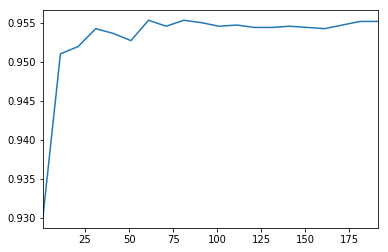

In [9]:
cv_errors.plot.line()
cv_errors.idxmax()

Since the cross-validation accuracy is maximized for $k=61$, we choose $k=61$ as the optimal model.

# Exercises

**Exercise 1.** Select variables from the Titanic data set (`/data301/data/titanic.csv`). Fit a $k$-nearest neighbors model to this data using Scikit-Learn. Use cross-validation to determine the optimal value of $k$ in terms of _precision_.

(_Hint:_ You will need to modify the `scoring=` parameter of `cross_val_score`.)

In [10]:
# YOUR CODE HERE

**Exercise 2.** Select variables from the Ames housing data set (`/data301/data/AmesHousing.txt`). Fit a $k$-nearest neighbors model to this data using Scikit-Learn. Use cross-validation to determine the optimal value of $k$ in terms of *mean squared error*.

(_Hint:_ You'll have to use `KNeighborsRegressor`, since this is a regression problem.)

In [11]:
# YOUR CODE HERE